<a href="https://colab.research.google.com/github/tousifo/ml_notebooks/blob/main/77_Qnn_with_Oaisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell to fix the PyTorch import error
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio

# IMPORTANT: After this cell finishes, go to the menu and click
# Runtime > Restart session
# before running any other code.

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ninadaithal_imagesoasis_path = kagglehub.dataset_download('ninadaithal/imagesoasis')

print('Data source import complete.')


Data source import complete.


In [6]:
# === IMPORTS ===
import os
# Set environment variables to potentially fix distributed import issues
os.environ['NCCL_P2P_DISABLE'] = '1'
os.environ['NCCL_IB_DISABLE'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pennylane as qml
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURATION ===
DATA_ROOT = "/kaggle/input/imagesoasis/Data"
LABEL_MAP = { "Non Demented": 0, "Very mild Dementia": 1, "Mild Dementia": 2, "Moderate Dementia": 3 }
class_names = list(LABEL_MAP.keys())

# === DATASET CLASS ===
class OASIS2DDataset(Dataset):
    def __init__(self, root_dir, class_names, transform=None, noise_std=0.7):
        self.data, self.labels = [], []
        self.transform = transform
        self.noise_std = noise_std
        for class_name in class_names:
            class_dir = os.path.join(root_dir, class_name)
            label = LABEL_MAP[class_name]
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(".jpg"):
                    self.data.append(os.path.join(class_dir, fname))
                    self.labels.append(label)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image = Image.open(self.data[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
        noisy_image = image + self.noise_std * torch.randn_like(image)
        patches = self.extract_patches(noisy_image)
        return torch.stack(patches), torch.tensor(self.labels[idx], dtype=torch.long)
    def extract_patches(self, image, patch_size=32, overlap_ratio=0.5):
        _, H, W = image.shape
        patches = []
        step = int(patch_size * (1 - overlap_ratio))
        if step == 0: step = 1
        for top in range(0, H - patch_size + 1, step):
            for left in range(0, W - patch_size + 1, step):
                patches.append(image[:, top:top+patch_size, left:left+patch_size])
        return patches

# === MODEL AND LOSS CLASSES ===
def create_qnode(n_qubits=4):
    dev = qml.device("default.qubit", wires=n_qubits)
    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def qnode(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
        qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    return qnode

class QNNMILClassifier(nn.Module):
    def __init__(self, n_qubits=4, num_classes=4):
        super().__init__()
        self.n_qubits = n_qubits
        self.qnode = create_qnode(n_qubits)
        self.q_layer = qml.qnn.TorchLayer(self.qnode, {"weights": (1, n_qubits)})
        self.attention = nn.Sequential(nn.Linear(n_qubits, 8), nn.Tanh(), nn.Linear(8, 1))
        self.classifier = nn.Linear(n_qubits, num_classes)
    def forward(self, patches, return_extras=False):
        B, N, C, H, W = patches.shape
        outputs = [self.q_layer(patches[:, i].reshape(B, -1)[:, :self.n_qubits]) for i in range(N)]
        patch_outputs = torch.stack(outputs, dim=1)
        attn_logits = self.attention(patch_outputs)
        attn_weights = F.softmax(attn_logits.squeeze(-1), dim=1)
        bag_rep = torch.sum(attn_weights.unsqueeze(-1) * patch_outputs, dim=1)
        logits = self.classifier(bag_rep)
        return (logits, attn_weights, bag_rep) if return_extras else logits

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
    def forward(self, z1, z2):
        sim = torch.matmul(F.normalize(z1), F.normalize(z2).T) / self.temperature
        return F.cross_entropy(sim, torch.arange(z1.size(0)).to(z1.device))

# === TRAINING AND VALIDATION FUNCTIONS ===
def train_joint(model, dataloader, optimizer, criterion_cls, criterion_cont, device):
    model.train()
    total_loss, all_preds, all_labels = 0.0, [], []
    for patches, labels in tqdm(dataloader, desc="Training"):
        patches, labels = patches.to(device), labels.to(device)
        noisy = patches + 0.3 * torch.randn_like(patches)
        logits_clean, logits_noisy = model(patches), model(noisy)
        loss = criterion_cls(logits_clean, labels) + 0.1 * criterion_cont(logits_clean, logits_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_preds.extend(torch.argmax(logits_clean, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return total_loss/len(dataloader), accuracy_score(all_labels, all_preds)

def validate(model, dataloader, criterion_cls, device):
    model.eval()
    total_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad():
        for patches, labels in tqdm(dataloader, desc="Validating"):
            patches, labels = patches.to(device), labels.to(device)
            logits = model(patches)
            total_loss += criterion_cls(logits, labels).item()
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss/len(dataloader), accuracy_score(all_labels, all_preds)

# === MAIN EXECUTION BLOCK ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
dataset = OASIS2DDataset(DATA_ROOT, class_names, transform=transform, noise_std=0.0)
train_set, test_set = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

model = QNNMILClassifier(n_qubits=4, num_classes=len(class_names)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn, contrast_fn = nn.CrossEntropyLoss(), ContrastiveLoss()

num_epochs = 1 # Training for 1 epochs
print(f"▶️ Starting training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_joint(model, train_loader, optimizer, loss_fn, contrast_fn, device)
    val_loss, val_acc = validate(model, test_loader, loss_fn, device)
    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Save the trained model's weights
torch.save(model.state_dict(), "qnn_model.pth")
print("\n✅ Training complete. Model saved to qnn_model.pth")

▶️ Starting training for 1 epochs...


Validating: 100%|██████████| 2161/2161 [20:20<00:00,  1.77it/s]

Epoch 01 | Train Loss: 0.8956 | Train Acc: 0.7762 | Val Loss: 0.6801 | Val Acc: 0.7794

✅ Training complete. Model saved to qnn_model.pth


In [7]:
# Save the trained model's weights to a file
torch.save(model.state_dict(), "qnn_model.pth")

print("✅ Model has been successfully saved to 'qnn_model.pth'")

✅ Model has been successfully saved to 'qnn_model.pth'



✅ Model loaded successfully. Generating visualizations...


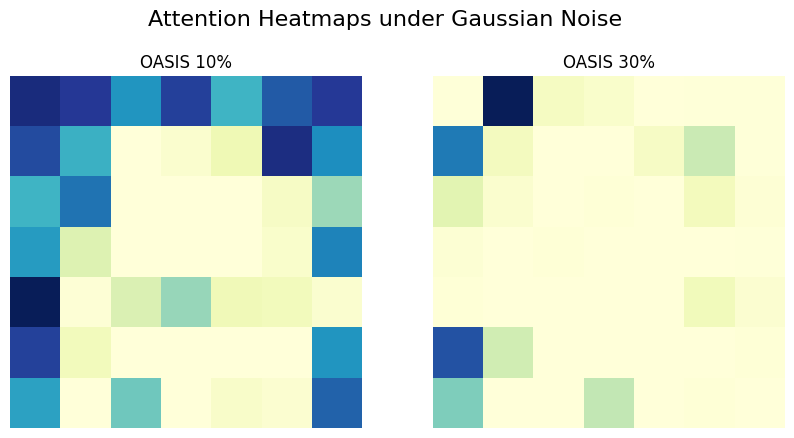


Generating t-SNE plot for 10% noise...


Extracting Embeddings: 100%|██████████| 2161/2161 [18:29<00:00,  1.95it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


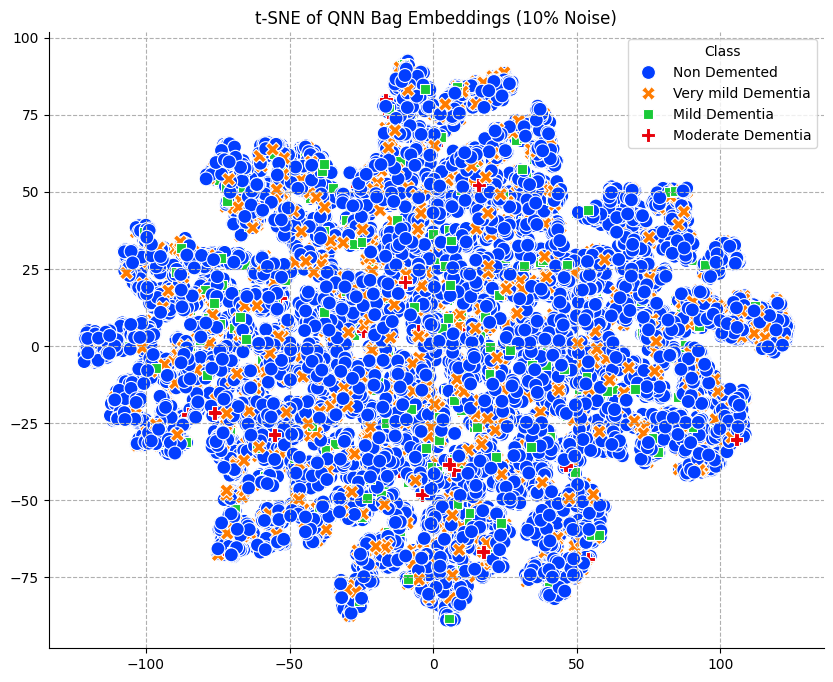

In [8]:
from sklearn.manifold import TSNE

# --- Redefine the Model Class ---
# We define the class again here to ensure the plotting functions have access
# to the 'return_extras' functionality.
def create_qnode(n_qubits=4):
    dev = qml.device("default.qubit", wires=n_qubits)
    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def qnode(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
        qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    return qnode

class QNNMILClassifier(nn.Module):
    def __init__(self, n_qubits=4, num_classes=4):
        super().__init__()
        self.n_qubits = n_qubits
        self.qnode = create_qnode(n_qubits)
        self.q_layer = qml.qnn.TorchLayer(self.qnode, {"weights": (1, n_qubits)})
        self.attention = nn.Sequential(nn.Linear(n_qubits, 8), nn.Tanh(), nn.Linear(8, 1))
        self.classifier = nn.Linear(n_qubits, num_classes)
    def forward(self, patches, return_extras=False):
        B, N, C, H, W = patches.shape
        outputs = [self.q_layer(patches[:, i].reshape(B, -1)[:, :self.n_qubits]) for i in range(N)]
        patch_outputs = torch.stack(outputs, dim=1)
        attn_logits = self.attention(patch_outputs)
        attn_weights = F.softmax(attn_logits.squeeze(-1), dim=1)
        bag_rep = torch.sum(attn_weights.unsqueeze(-1) * patch_outputs, dim=1)
        logits = self.classifier(bag_rep)
        return (logits, attn_weights, bag_rep) if return_extras else logits

# --- Plotting Functions ---
def plot_attention_heatmap(model, data_loader, device, noise_levels=[0.1, 0.3]):
    """Generates and plots attention heatmaps for a sample image."""
    model.eval()
    sample_patches, _ = next(iter(data_loader))
    sample_patches = sample_patches[0].unsqueeze(0).to(device)
    grid_size = int(np.sqrt(sample_patches.shape[1]))

    fig, axes = plt.subplots(1, len(noise_levels), figsize=(10, 5))
    fig.suptitle("Attention Heatmaps under Gaussian Noise", fontsize=16)

    for i, noise_std in enumerate(noise_levels):
        ax = axes[i]
        with torch.no_grad():
            _, attn_weights, _ = model(sample_patches + noise_std * torch.randn_like(sample_patches), return_extras=True)
        sns.heatmap(attn_weights.cpu().numpy().reshape(grid_size, grid_size), cmap="YlGnBu", cbar=False, ax=ax, square=True)
        ax.set_title(f"OASIS {int(noise_std*100)}%")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig("attention_heatmap_generated.png")
    plt.show()

def plot_tsne_embeddings(model, data_loader, device, noise_level=0.1):
    """Generates a t-SNE plot of the bag embeddings for the test set."""
    model.eval()
    all_embeddings, all_labels = [], []
    print(f"\nGenerating t-SNE plot for {int(noise_level*100)}% noise...")

    with torch.no_grad():
        for patches, labels in tqdm(data_loader, desc="Extracting Embeddings"):
            # The model's forward pass now has the 'return_extras' flag
            # Noise is added here:
            _, _, bag_rep = model(patches.to(device) + noise_level * torch.randn_like(patches), return_extras=True)
            all_embeddings.append(bag_rep.cpu())
            all_labels.append(labels.cpu())

    tsne_results = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42).fit_transform(torch.cat(all_embeddings))

    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=torch.cat(all_labels),
        palette=sns.color_palette("bright", n_colors=len(class_names)), style=torch.cat(all_labels), s=100)
    plt.title(f"t-SNE of QNN Bag Embeddings ({int(noise_level*100)}% Noise)")
    handles, _ = scatter.get_legend_handles_labels()
    scatter.legend(handles, class_names, title="Class")
    plt.grid(True, linestyle='--')
    sns.despine()
    plt.savefig("tsne_embeddings_generated.png")
    plt.show()

# --- Load Model and Generate Plots ---
# 1. Create a new instance of the model
plotting_model = QNNMILClassifier(n_qubits=4, num_classes=len(class_names)).to(device)

# 2. Load the weights you saved from the trained model
plotting_model.load_state_dict(torch.load("qnn_model.pth"))

print("\n✅ Model loaded successfully. Generating visualizations...")

# 3. Call the plotting functions
# Note: This assumes 'test_loader', 'device', and 'class_names' are still in memory from the previous cell.
plot_attention_heatmap(plotting_model, test_loader, device)
# Change the noise_level argument here to modify the noise for the t-SNE plot:
plot_tsne_embeddings(plotting_model, test_loader, device, noise_level=0.1)


✅ Model loaded. Generating corrected attention overlay image...


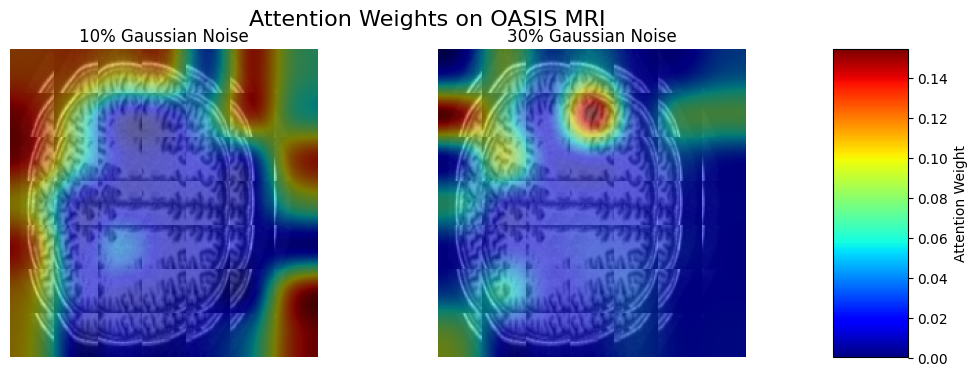

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import transforms

# --- Redefine the Model Class ---
# We need the model's structure to load the saved weights.
def create_qnode(n_qubits=4):
    dev = qml.device("default.qubit", wires=n_qubits)
    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def qnode(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
        qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    return qnode

class QNNMILClassifier(nn.Module):
    def __init__(self, n_qubits=4, num_classes=4):
        super().__init__()
        self.n_qubits = n_qubits
        self.qnode = create_qnode(n_qubits)
        self.q_layer = qml.qnn.TorchLayer(self.qnode, {"weights": (1, n_qubits)})
        self.attention = nn.Sequential(nn.Linear(n_qubits, 8), nn.Tanh(), nn.Linear(8, 1))
        self.classifier = nn.Linear(n_qubits, num_classes)
    def forward(self, patches, return_extras=False):
        B, N, C, H, W = patches.shape
        outputs = [self.q_layer(patches[:, i].reshape(B, -1)[:, :self.n_qubits]) for i in range(N)]
        patch_outputs = torch.stack(outputs, dim=1)
        attn_logits = self.attention(patch_outputs)
        attn_weights = F.softmax(attn_logits.squeeze(-1), dim=1)
        bag_rep = torch.sum(attn_weights.unsqueeze(-1) * patch_outputs, dim=1)
        logits = self.classifier(bag_rep)
        return (logits, attn_weights, bag_rep) if return_extras else logits


# --- CORRECTED Plotting Function for Overlays ---
def plot_attention_overlay(model, data_loader, device, noise_levels=[0.1, 0.3]):
    """
    Generates and plots attention weights overlaid on the original MRI scan.
    """
    model.eval()

    # 1. Get a batch of data
    batch_of_patches, _ = next(iter(data_loader))

    # 2. **FIX**: Isolate a SINGLE image from the batch for plotting.
    # This ensures the model processes one image (49 patches), not the whole batch (392 patches).
    single_image_patches = batch_of_patches[0].unsqueeze(0).to(device)

    # 3. Reconstruct the base image from its clean patches for visualization
    grid_size = int(np.sqrt(single_image_patches.shape[1]))
    base_image = torch.cat(tuple(torch.cat(tuple(single_image_patches[0, i*grid_size:(i+1)*grid_size, 0]), dim=1) for i in range(grid_size)), dim=0).cpu().numpy()

    # 4. Create the plot
    fig, axes = plt.subplots(1, len(noise_levels) + 1, figsize=(12, 4),
                           gridspec_kw={'width_ratios': [1, 1, 0.2]})
    fig.suptitle("Attention Weights on OASIS MRI", fontsize=16)

    for i, noise_std in enumerate(noise_levels):
        ax = axes[i]
        with torch.no_grad():
            # Get attention weights for the noisy version of the SINGLE image
            _, attn_weights, _ = model(single_image_patches + noise_std * torch.randn_like(single_image_patches), return_extras=True)

        # Reshape attention weights (now correctly sized 49) into a 7x7 grid
        attn_grid = attn_weights.cpu().numpy().reshape(grid_size, grid_size)

        # Upscale the low-res attention grid to the full image size
        attn_image = np.array(Image.fromarray(attn_grid).resize((base_image.shape[1], base_image.shape[0]), Image.BICUBIC))

        # Plot the base MRI and the attention overlay
        ax.imshow(base_image, cmap='gray')
        ax.imshow(attn_image, cmap='jet', alpha=0.5)
        ax.set_title(f"{int(noise_std*100)}% Gaussian Noise")
        ax.axis('off')

    # Add a colorbar
    norm = plt.Normalize(vmin=attn_grid.min(), vmax=attn_grid.max())
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='jet', norm=norm), cax=axes[-1], orientation='vertical')
    cbar.set_label('Attention Weight')

    plt.savefig("attention_overlay_generated.png")
    plt.show()


# --- Load Model and Generate Plot ---
# Note: Assumes 'device' and 'test_loader' are available in your environment.
# 1. Create a new instance of the model
overlay_model = QNNMILClassifier(n_qubits=4, num_classes=len(class_names)).to(device)

# 2. Load the weights from the file you saved
overlay_model.load_state_dict(torch.load("qnn_model.pth"))

print("\n✅ Model loaded. Generating corrected attention overlay image...")

# 3. Call the corrected plotting function
plot_attention_overlay(overlay_model, test_loader, device)